<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/image_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [1]:
%%capture
!pip -q install rasterio
!pip -q install torch
!pip -q install torchvision
!pip -q install albumentations
!pip -q install segmentation-models-pytorch
!pip -q install tqdm

In [26]:
import os
import torch
import rasterio
import rasterio.features
from rasterio.features import rasterize
import json
from shapely.geometry import LineString, Polygon
import albumentations as A
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import numpy as np
import cv2
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA


# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Download  data to local compute node

## Mount your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress files, copy over to compute node, and uncompress

In [ ]:
# Navigate to the shared directory
#%cd /content/drive/MyDrive/Zindi-Amazon/
#!zip -r /content/predictions.zip WhateverDirectory
#!unzip /content/predictions.zip -d /content

/content/drive/.shortcut-targets-by-id/14mw0v8Bi-MzhsqSI0K3KO23YrUHttM7P/Zindi-Amazon/training
  adding: images/ (stored 0%)
  adding: images/Sentinel_AllBands_Training_Id_59.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_61.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_78.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_79.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_105.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_120.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_135.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_176.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_157.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_148.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_17.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_99.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_172.ti

# Description of process

Here's a method to identify clusters, fit lines to each one, and extract the endpoints and lengths. We'll start by identifying clusters, then fit lines to each, and finally calculate endpoints and filter based on length-to-width ratios.

**Step-by-Step Method:**
1.   **Identify Clusters:** We can identify clusters of connected pixels in the binary mask using connected component analysis. Each cluster corresponds to a connected component in the binary mask.
2.   **Fit a Line to Each Cluster:** For each identified cluster, fit a line using Principal Component Analysis (PCA), which will help determine the main axis of elongation for the cluster. The endpoints of the fitted line can be computed along this principal component.
3.   **Extract Lengths and Calculate Length/Width Ratios:** Once we have the principal component direction, calculate the length of the line by projecting the points onto the main axis. The width can be computed as the spread of points orthogonal to this main axis, allowing for length-to-width ratio calculations.
4.   **Reject bad clusters:** Airstrips are long and narrow. In the training set, the shortest LINESTRING was 376 meters. With a 20-meter buffer, the mininal lenght of the prediction shoud be over 400 meters. If we reject all clusters that do not intersect the bounding box, and are less than 300 meters long (30 pixels), we shoud remove almost all short road or dry river bed segments. For clusters that intersect the bounding box, we are not going to cut them based on the line segment lenght. If it looks like a problem, we'll devise a different cut.


In [65]:
def process_clusters(binary_mask, min_length=30, max_width=6):
    """
    Identifies and processes clusters (connected components) in the binary mask.
    """

    # Label connected components in the mask
    labeled_mask = label(binary_mask)
    clusters = regionprops(labeled_mask)
    image_height, image_width = binary_mask.shape  # Get image dimensions

    lines = []

    for cluster in clusters:
        # Check if the cluster has enough points for PCA
        if cluster.area < 2:  # At least 2 points needed for PCA
            # Handle clusters with insufficient points (e.g., skip, merge, etc.)
            print(f"Skipping cluster with {cluster.area} points - insufficient for PCA.")
            continue  # Skip this cluster

        # Extract the coordinates of the pixels in the cluster
        coords = cluster.coords

        # Perform PCA to find the main axis
        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        variance = pca.explained_variance_

        # Compute the length of the cluster along the principal axis
        projected_coords = coords @ direction
        min_proj, max_proj = projected_coords.min(), projected_coords.max()
        length = max_proj - min_proj

        # Calculate width by projecting orthogonal to main axis
        orthogonal_direction = pca.components_[1]
        orthogonal_proj = coords @ orthogonal_direction
        width = orthogonal_proj.max() - orthogonal_proj.min()

        # Compute length-to-width ratio
        length_width_ratio = length / width if width != 0 else np.inf

        # Check if line touches the border:
        touches_border = any(
            (x == 0 or x == image_width - 1 or y == 0 or y == image_height - 1)
            for x, y in coords
        )


        # Filter based on length and border condition and width
        if (width <= max_width) and ((length >= min_length and not touches_border) or (touches_border)):
            # Get endpoints of the line along the main axis
            endpoint1 = pca.mean_ + direction * (min_proj - pca.mean_ @ direction)
            endpoint2 = pca.mean_ + direction * (max_proj - pca.mean_ @ direction)
            lines.append({
                "length": length,
                "width": width,
                "ratio": length_width_ratio,
                "endpoints": (endpoint1, endpoint2)
            })

    return lines

In [59]:
def plot_clusters_and_lines(binary_mask, lines):
    plt.figure(figsize=(20,20))  # Set figure size
    plt.imshow(binary_mask, cmap="gray")
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]
        plt.plot([y1, y2], [x1, x2], 'r-')
    plt.show()


In [11]:
def load_binary_mask_from_geotiff(geotiff_path):
    """
    Loads the binary mask from a GeoTIFF file and returns it as a NumPy array.
    """
    with rasterio.open(geotiff_path) as src:
        # Read the first band (assuming the binary mask is single-band and in the first band)
        binary_mask = src.read(1)

    # Ensure mask is binary (values should be 0 or 1)
    binary_mask = (binary_mask > 0).astype(np.uint8)

    return binary_mask


In [20]:
def lines_to_geojson(lines, geotiff_path, buffer_distance=200):
    """
    Converts lines with pixel coordinates to GeoJSON LINESTRING features
    using the GeoTIFF metadata, including the CRS.

    Args:
        lines: A list of line dictionaries, each with "endpoints" key.
        geotiff_path: Path to the GeoTIFF file.
        buffer_distance: Buffer distance in meters.

    Returns:
        A GeoJSON FeatureCollection containing the Polygon features with buffer.
    """

    with rasterio.open(geotiff_path) as src:
        transform = src.transform
        crs = src.crs

    features = []
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]

        # Convert pixel coordinates to geographic coordinates
        lon1, lat1 = rasterio.transform.xy(transform, x1, y1)
        lon2, lat2 = rasterio.transform.xy(transform, x2, y2)

        # Create Shapely LineString
        line_geom = LineString([(lon1, lat1), (lon2, lat2)])

        # Buffer the LineString (assuming UTM coordinates)
        polygon_geom = line_geom.buffer(buffer_distance)

        # Create GeoJSON Polygon feature
        feature = {
            "type": "Feature",
            "geometry": polygon_geom.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"]
            }
        }
        features.append(feature)

    # Create GeoJSON FeatureCollection with CRS
    geojson = {
        "type": "FeatureCollection",
        "features": features,
        "crs": {
            "type": "name",
            "properties": {
                "name": crs.to_string()  # Get CRS as a string
            }
        }
    }

    return geojson


In [35]:
def create_mask_from_geojson(geojson_data, geotiff_path, output_path):
    """
    Creates a new GeoTIFF mask from GeoJSON polygons,
    using the metadata of an existing GeoTIFF.

    Args:
        geojson_data: The GeoJSON data containing the polygons.
        geotiff_path: Path to the original GeoTIFF file.
        output_path: Path to save the new GeoTIFF mask.
    """

    with rasterio.open(geotiff_path) as src:
        # Get metadata from original GeoTIFF
        meta = src.meta.copy()

        # Update data type to uint8 for binary mask
        meta.update(dtype=rasterio.uint8, count=1, nodata=None)

        # Create an empty mask array
        mask = np.zeros((meta['height'], meta['width']), dtype=rasterio.uint8)

        # Rasterize GeoJSON polygons onto the mask with value 1
        for feature in geojson_data['features']:
            # Burn the polygon with a value of 1
            # Use rasterio.features.rasterize instead of features.rasterize
            rasterio.features.rasterize(
                [(feature['geometry'], 1)],
                out=mask,
                transform=meta['transform'],
                all_touched=True,
                default_value=1,  # Set polygon value to 1
                dtype=rasterio.uint8,
            )

        # Write the new mask to a GeoTIFF file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(mask, indexes=1)


# Main loop

This is where we load the GeoTIFF file prediction, find the clusters,
clean the image and then produce a final prediction. Notice that the final prediction must have a 200 meter buffer.

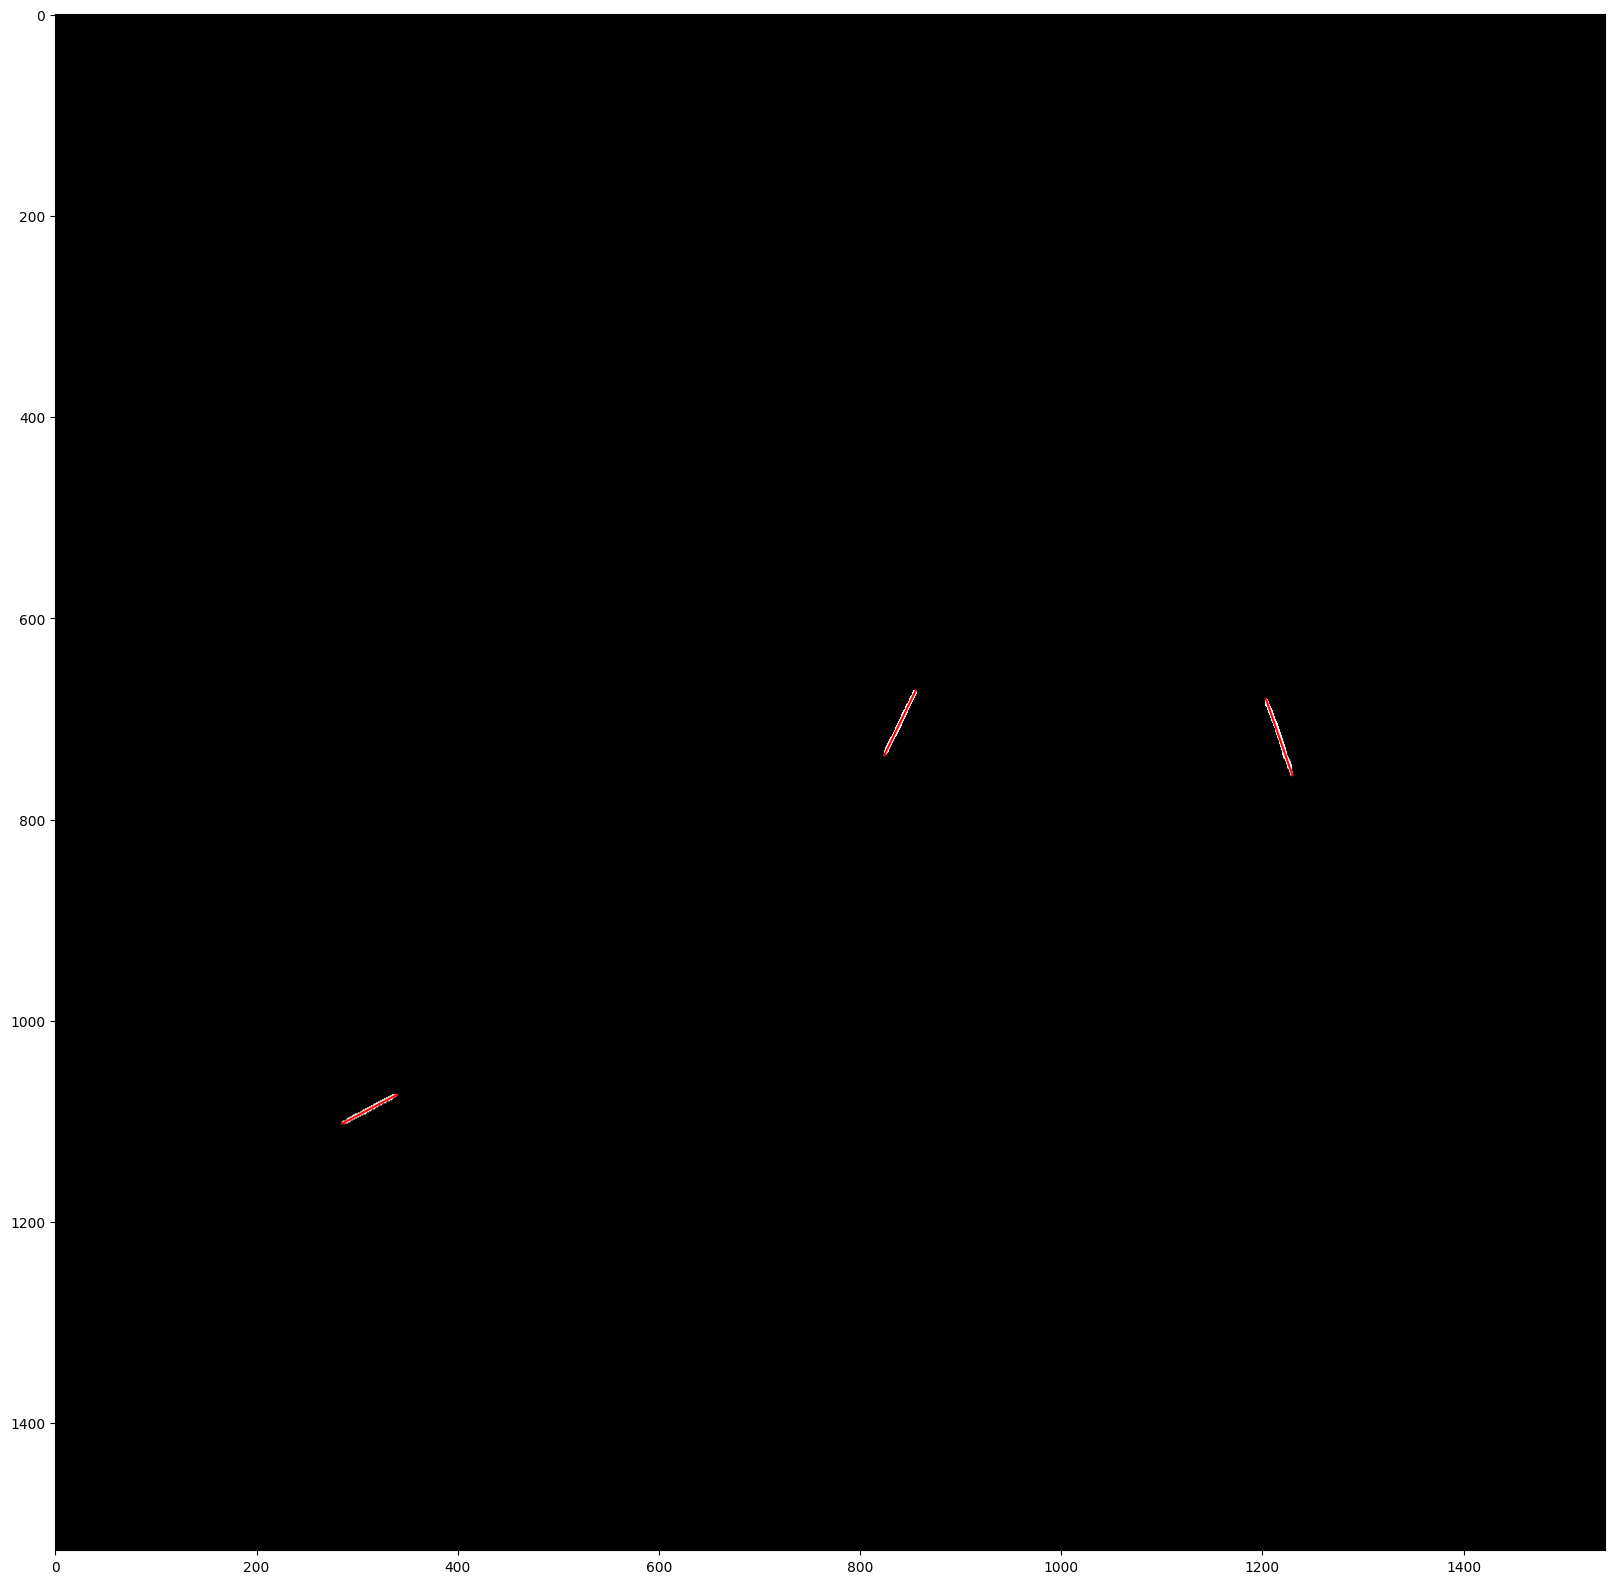

Length: 71.5496267095435, Width: 4.808102561875785, Ratio: 14.881052512663093
Endpoints: (array([671.71057842, 855.40446274]), array([736.06322858, 824.13010424]))
Length: 80.65132603241341, Width: 5.473493334542468, Ratio: 14.734890700137319
Endpoints: (array([ 679.82789419, 1203.49617492]), array([ 756.02550377, 1229.92647353]))
Length: 61.71103294536573, Width: 4.7088461394325805, Ratio: 13.105340696649298
Endpoints: (array([1102.2685007,  285.1414649]), array([1073.50312519,  339.73821168]))


In [66]:
geotiff_path = '/content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_VV/aoi_2022_01_prediction_mosaic.tif'
binary_mask = load_binary_mask_from_geotiff(geotiff_path)
lines = process_clusters(binary_mask)

plot_clusters_and_lines(binary_mask, lines)


# Output the line information
for line in lines:
    print(f"Length: {line['length']}, Width: {line['width']}, Ratio: {line['ratio']}")
    print(f"Endpoints: {line['endpoints']}")


# Convert lines to GeoJSON object.
geojson_data = lines_to_geojson(lines, geotiff_path)


# Create final mask:
create_mask_from_geojson(geojson_data, geotiff_path, 'aoi_2022_01_prediction_final.tif')


# Save to a file (optional)
#with open('lines.geojson', 'w') as f:
#    json.dump(geojson_data, f, indent=2)
